# Stock Trend Prediction using Convolutional Neural Network
Team Member: Xiaohan Zhao, Xiaochen Wang, Ziqing Luo, Sheng Yang, Chao Wang

## Problem Description
In this project, our goal is to predict the direction of time series in a short-term window, specifically, the next five days, as either up, down, or unchanged. This task is essential for investors and traders who want to make informed decisions in a fast-paced and constantly changing market. By leveraging historical data, we aim to build a model that can accurately predict price movements. These predictions can help investors and traders to optimize their strategies and manage their risks in the market.


## Data Description 
### Data Source
In this project, we analyze five datasets, each representing a Chinese stock market index: the SSE 50 Index (sh000016), CSI 300 Index (sh000300), CSI 1000 Index (sh000852), CSI 100 Index (sh000903), and CSI 500 Index (sh000905). The datasets contain daily historical data for each index from December 31, 2009, to March 27, 2023, sourced from a reliable financial data provider. Our goal is to predict the direction of the mean stock price movement for the next five days (up, down, or unchanged) based on the close, volume, and money columns.


### Explanation for Each Variable
Each index comes as a csv file. We would only make use the following four columns:
- `date`: str, the trading day in the format YYYY-MM-DD (will be used as reference only).
- `open`: The opening price of the index on each trading day.
- `close`: float, the closing price of the index on each trading day.
- `high`: The highest price reached by the index on each trading day.
- `low`: The lowest price reached by the index on each trading day.
- `volume`: float, the total number of shares traded on each trading day.
- `money`: float, the total turnover on each trading day.
- `change`: The percentage change in the index’s closing price compared to the previous trading day.
- `adjclose`: The adjusted closing price, which accounts for dividends, stock splits, or new stock offerings. 
- `symbol`: The stock code representing each index.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm


In [2]:
#read raw data
sh16= pd.read_csv("../data/raw/sh000016.csv")
sh300 = pd.read_csv("../data/raw/sh000300.csv")
sh852 = pd.read_csv("../data/raw/sh000852.csv")
sh903 = pd.read_csv("../data/raw/sh000903.csv")
sh905 = pd.read_csv("../data/raw/sh000905.csv")

#Convert date column into the right format
sh16['date'] = pd.to_datetime(sh16['date'])
sh300['date'] = pd.to_datetime(sh300['date'])
sh852['date'] = pd.to_datetime(sh852['date'])
sh903['date'] = pd.to_datetime(sh903['date'])
sh905['date'] = pd.to_datetime(sh905['date'])

# Set date as index
sh16.set_index('date', inplace=True)
sh300.set_index('date', inplace=True)
sh852.set_index('date', inplace=True)
sh903.set_index('date', inplace=True)
sh905.set_index('date', inplace=True)

In [3]:
#read processed data
X_16 = np.load("../data/preprocessed/000016/X.npy")
y_16 = np.load("../data/preprocessed/000016/y.npy")
X_300 = np.load("../data/preprocessed/000300/X.npy")
y_300 = np.load("../data/preprocessed/000300/y.npy")
X_852 = np.load("../data/preprocessed/000852/X.npy")
y_852 = np.load("../data/preprocessed/000852/y.npy")
X_903 = np.load("../data/preprocessed/000903/X.npy")
y_903 = np.load("../data/preprocessed/000903/y.npy")
X_905 = np.load("../data/preprocessed/000905/X.npy")
y_905 = np.load("../data/preprocessed/000905/y.npy")

### Descriptive Statistics

Here is an descriptive statistics summary for one of the 5 indexes.

In [4]:
sh16.head(2)

,open,close,high,low,volume,money,change,adjclose,symbol
date,,,,,,,,,
2009-12-31,2545.86,2553.80,2563.97,2535.69,33063231.0,4.243017e+10,1.11,2553.80,sh000016
2010-01-04,2565.11,2514.65,2570.15,2514.24,27327443.0,3.646852e+10,2.19,2514.65,sh000016


In [5]:
sh16.describe()

,open,close,high,low,volume,money,change,adjclose
count,3215.000000,3215.000000,3215.000000,3215.000000,3.215000e+03,3.215000e+03,3215.000000,3215.000000
mean,2404.218420,2405.620955,2425.056364,2384.480855,3.549837e+07,5.065005e+10,1.689944,2405.620955
std,590.784039,590.433371,594.870099,585.421186,3.237605e+07,4.631475e+10,1.092605,590.433371
min,1402.810000,1406.920000,1420.900000,1402.180000,7.220379e+06,7.294749e+09,0.290000,1406.920000
25%,1890.805000,1894.385000,1907.425000,1874.270000,2.025813e+07,2.177911e+10,1.020000,1894.385000
50%,2383.960000,2386.380000,2409.130000,2367.050000,2.666248e+07,3.589445e+10,1.390000,2386.380000
75%,2854.790000,2855.795000,2875.385000,2834.325000,3.708133e+07,6.396047e+10,2.010000,2855.795000
max,4097.870000,4028.530000,4110.180000,3996.630000,3.774594e+08,4.282975e+11,12.840000,4028.530000


## Data Preprocessing

**Preprocess features**

Our model takes stock features as input to predict price moving trend. We stack the 3 predictors, close, volume and turnover, in the previous $T = 100$ days to form $\mathbf{X_n} \in \mathbb{R}^{100×3}$. Within each $\mathbf{X_n}$, we standardize each column. Observe this is drastically different from standardization for images.

**Compute the target variable**

The target $y_n$ is a categorical variable with 3 levels, indicating the downward, stationary and upward price moving trend. It is defined as
\begin{equation}
    \Delta p_T = \frac{\frac{1}{k}\sum_{i=1}^{k}p_{T+i}-p_T}{p_T}, \;\;\;\;\; y_n = 
    \begin{cases}
        -1 & \Delta p_T \leqslant -\alpha \\
        0  & -\alpha < \Delta p_T < \alpha \\
        1  & \Delta p_T \geqslant \alpha
    \end{cases}
\end{equation}

where $\alpha$ is the threshold for trend direction judgment and $\Delta p_T$ is the percentage change of the future mid-price compared with the current price. We choose $\alpha=0.007$ and $k = 5$.

## Exploratory Data Analysis

### Close Price Trends

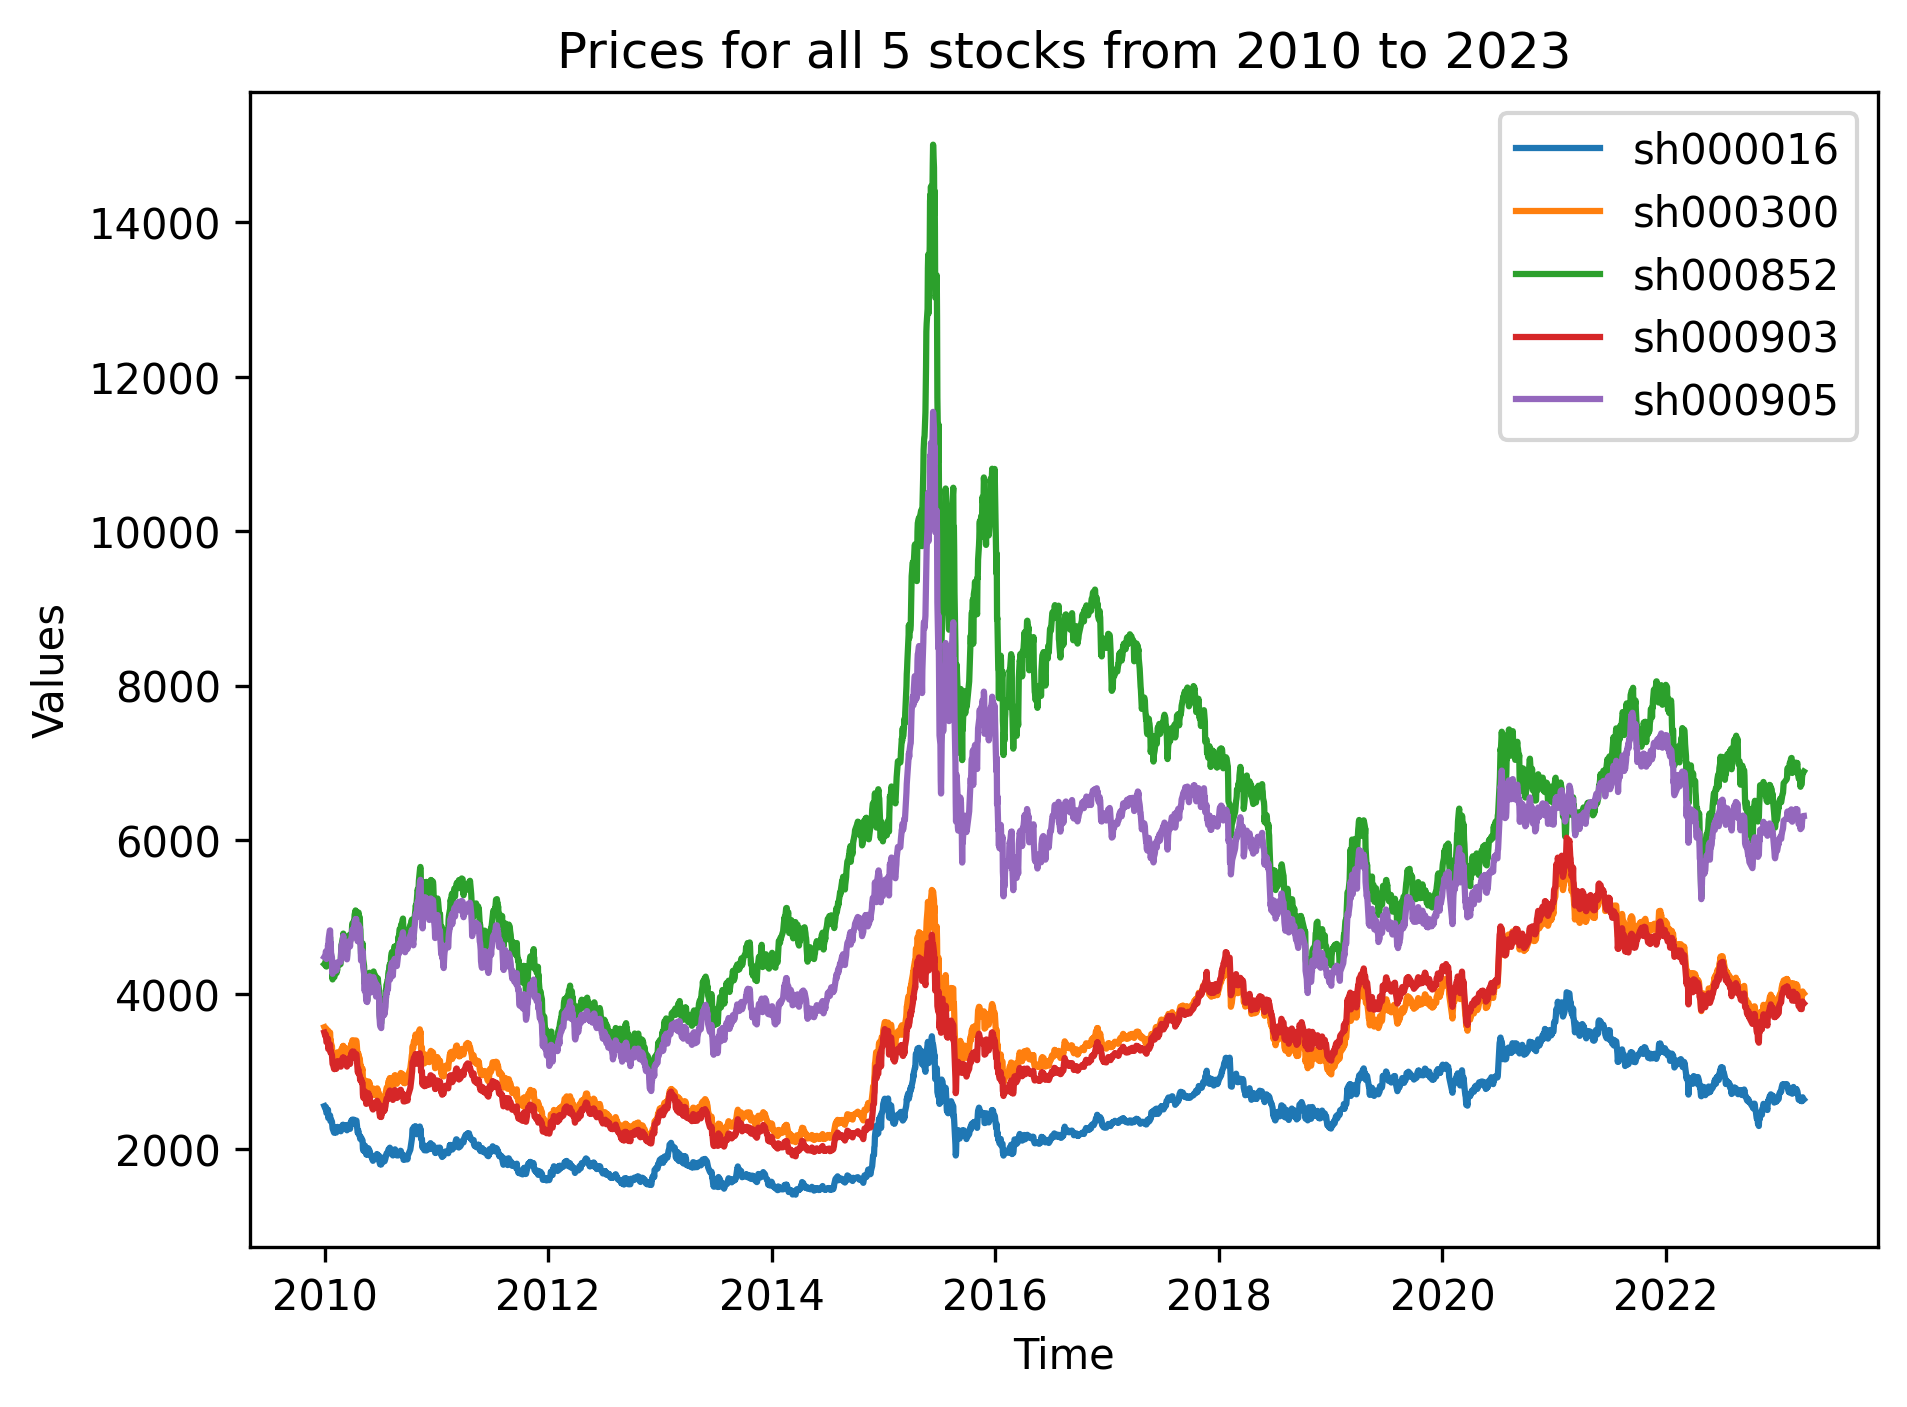

In [7]:
plt.figure(figsize=(7,5),dpi=300)
plt.plot(sh16['close'],label = 'sh000016')
plt.plot(sh300['close'],label = 'sh000300')
plt.plot(sh852['close'],label = 'sh000852')
plt.plot(sh903['close'],label = 'sh000903')
plt.plot(sh905['close'],label = 'sh000905')

# set the plot title, axis labels, and legend
plt.title('Prices for all 5 stocks from 2010 to 2023')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

plt.savefig("price_trends.png")

Observations:
- In 2015, there's a peak in the close prices of all 5 examined stocks. It was a time when China's economy was growing rapidly and this fueled investor confidence and contributed to the stock market boom. The Chinese governemnt also lowered interest rates at that time and made it easier for people to access credit, leading to a surge in investments in the stock market.

### Close Price Trends with Moving Average

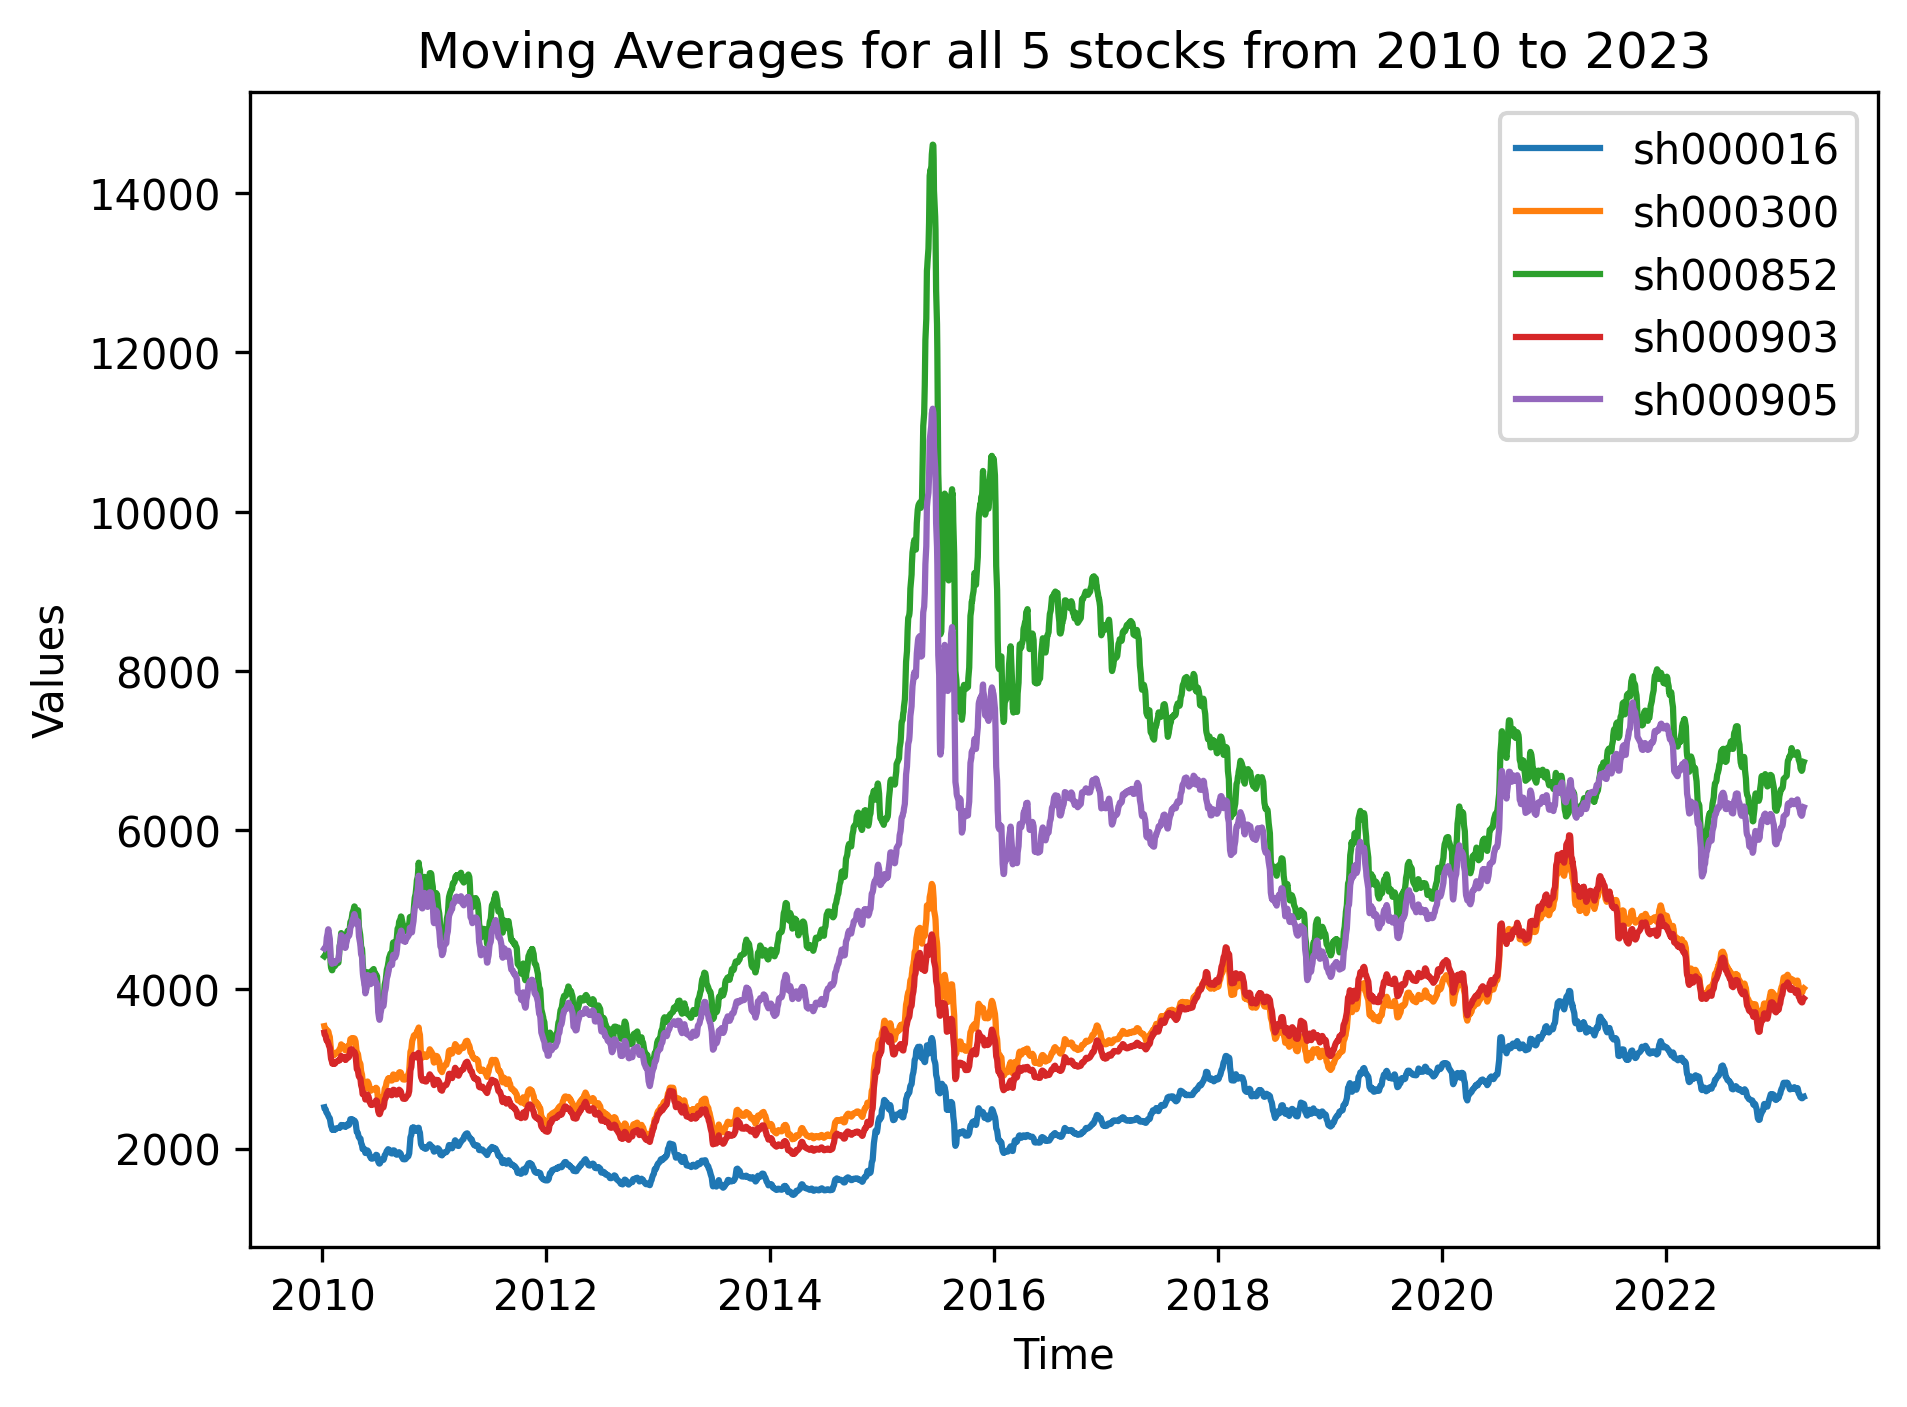

In [8]:
plt.figure(figsize=(7,5),dpi=300)
plt.plot(sh16['close'].rolling(window=5).mean(),label = 'sh000016')
plt.plot(sh300['close'].rolling(window=5).mean(),label = 'sh000300')
plt.plot(sh852['close'].rolling(window=5).mean(),label = 'sh000852')
plt.plot(sh903['close'].rolling(window=5).mean(),label = 'sh000903')
plt.plot(sh905['close'].rolling(window=5).mean(),label = 'sh000905')

# set the plot title, axis labels, and legend
plt.title('Moving Averages for all 5 stocks from 2010 to 2023')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

plt.savefig("price_trends_ma.png")

Observation:
- In addition, we observe that the daily stock prices are highly volatile and can experience a wide range of fluctuations over time. Using the next single day price to determine the trend may lead to unstable results. To address this, we use a moving average to reduce the noise in the data and obtain a clearer representation of the underlying trend. By calculating the average price over a specified period (e.g., $k=5$ days), we can create a smoother curve that captures the general movement of the stock prices, which is expected to facilitate forecasting. 

### Feature Correlations

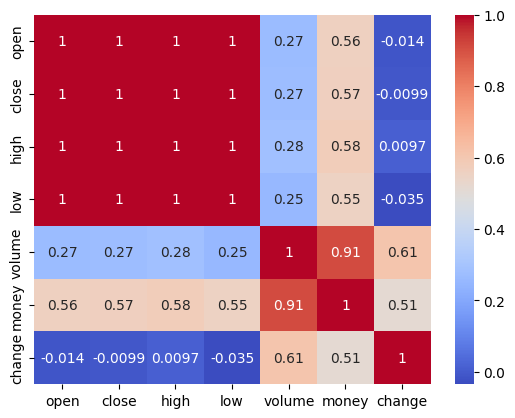

In [31]:
heatmap = sns.heatmap(sh16.iloc[:, 0:7].corr(),cmap='coolwarm',annot=True)
heatmap.get_figure().savefig("heatmap.png")

From the heatmap above, it is evident that the variables `open`, `close`, `high`, `low`, and `adjclose` exhibit strong positive linear relationships. As a result, we opt to use only the `close` price as our feature and exclude the others. The correlation coefficient between `close` and `volume` is 0.27, while the correlation between `close` and `money` is 0.57. Based on these values, we decide to retain both `volume` and `money` as features in our analysis.

### Distribution of Predictors

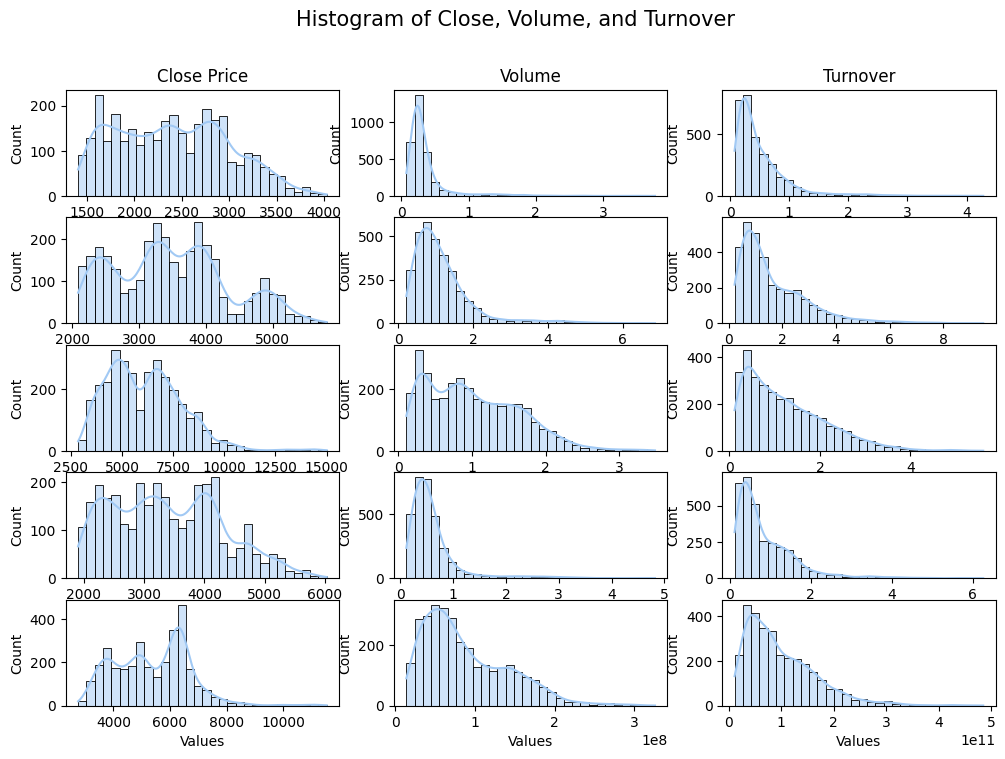

In [34]:
# Create a 5x3 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 8))

# Define a list of column names for the three types of data
data_cols = ['close', 'volume', 'money']

# Loop over the rows and columns of the grid
for i in range(5):
    if i == 0:
        stock = sh16
        label = sh16
    elif i == 1:
        stock = sh300
        label = sh300
    elif i == 2:
        stock = sh852
        label = sh852
    elif i == 3:
        stock = sh903
        label = sh903
    else:
        stock = sh905
        label = sh905
    for j in range(3):
        # Get the variable that needs to be visualized
        col = data_cols[j]

        # Plot the data on the current subplot
        sns.histplot(stock[[col]], ax=axs[i,j],kde=True,bins=30,legend=False)
     #   stock_data.plot(ax=axs[i,j], label=label)
        axs[i,j].set_xlabel('Values')
     #   axs[i,j].set_ylabel(col.capitalize())
      #  axs[i,j].legend()
axs[0, 0].set_title('Close Price')
axs[0, 1].set_title('Volume')
axs[0, 2].set_title('Turnover')
plt.suptitle("Histogram of Close, Volume, and Turnover", fontsize=15)
# Show the plot
plt.show()


fig.savefig("histograms.png")

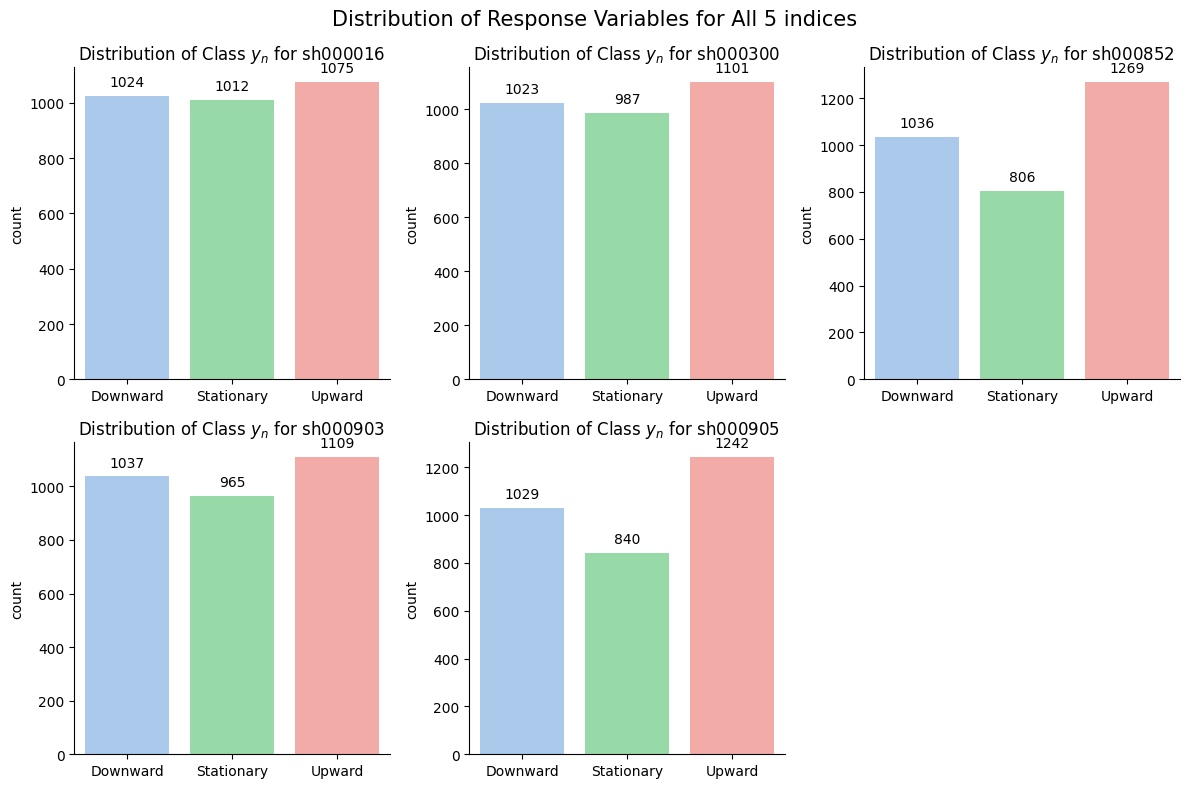

In [35]:
sns.set_palette('pastel6')
#fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
label_dict = {2:'Downward', 0:'Stationary', 1:'Upward'} #2, 0, 1
stock_label = ['sh000016','sh000300','sh000852','sh000903','sh000905']
#set up subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
# axes = axes.flatten()


y_s = [y_16,y_300,y_852,y_903,y_905]

for i, stock in enumerate(y_s):
# Map the array values to their corresponding labels
    label_arr = [label_dict[val] for val in stock]

    ax = sns.countplot(x = label_arr,order=['Downward', 'Stationary','Upward'],ax=axes[i//3,i%3])
    ax.set(title=f"Distribution of Class $y_n$ for {stock_label[i]} ")
    # Add count labels on top of the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10),
                    textcoords='offset points')

    
# # Remove any unused subplots
# for i in range(len(y_s), len(axes)):
#     fig.delaxes(axes[i])
axes[1,2].remove()
plt.suptitle("Distribution of Response Variables for All 5 indices", fontsize=15)

# Adjust the layout of the subplots
fig.tight_layout()

# Show the plot
sns.despine()
plt.show()

fig.savefig("yn_distribution.png")

We take a look at the distribution of the 3 predictors that we will be using to predict the pricing trend. As we can observe in the histograms above, even after standardization, `volume` and `money` are still quite right-skewed. This may imply that we should use non-parametric models that do not assume a specific distribution of the prediction to perform the prediction task.

### Autocorrelation

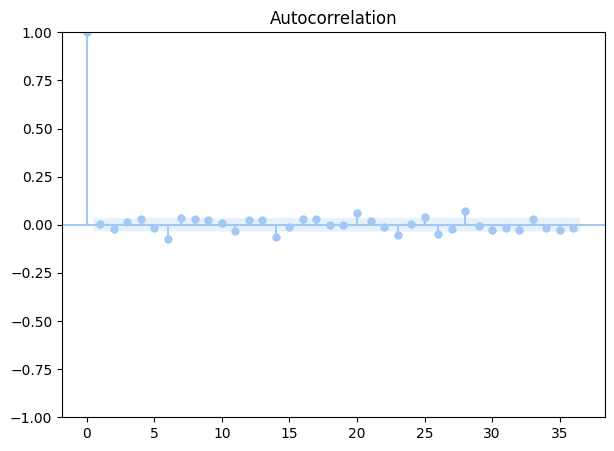

In [29]:
# Plot autocorrelation
fig, ax = plt.subplots(figsize=(7, 5))
price_return = sh16['close'] / sh16['close'].shift(1)
sm.graphics.tsa.plot_acf(price_return[1:], ax=ax)
plt.show()

/Users/kenneth/opt/anaconda3/envs/stp/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


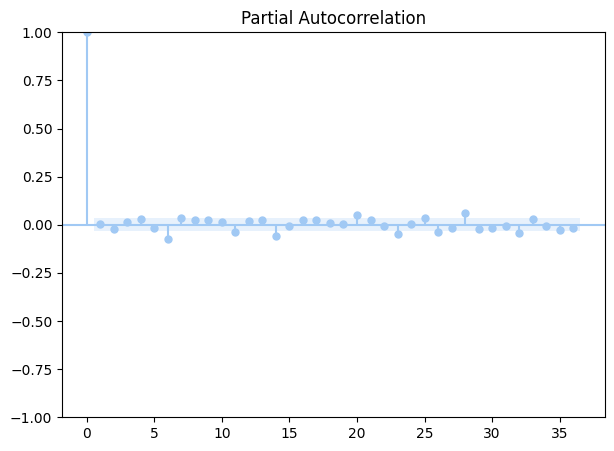

In [36]:
# Plot autocorrelation
fig, ax = plt.subplots(figsize=(7, 5))
price_return = sh16['close'] / sh16['close'].shift(1)
sm.graphics.tsa.plot_pacf(price_return[1:], ax=ax)
plt.show()

The autocorrelation and partial autocorrelation plots indicate a biweekly negative autocorrelation. The presence of a momentum effect, such as a rise in the market followed by a fall the following week, can be identified by a positive partial autocorrelation at a lag of one week.

### Examine the Target Variable

We examined the distribution of the target variable $y_{n}$ for all 5 stocks. In general, there are no significant class imbalance issues with our chosen threshold $\alpha=0.007$. However, we can see that compared with sh000016, sh000300, sh000903, sh000852 and sh000905 have more "upward" moving trends. This suggests that each stock has its own unique characteristics and factors that affect its price. In light of this, we will build separate models to capture the unique characteristic of each stock. 

### Noteworthy Findings and Meaningful Insights
Based on the previous Exploratory Data Analysis, here is a summary of our main findings and insights:

- **Market style changes dramatically across time**: for example, all indices experienced a price peak in 2015, which was a result of an excessive amount of speculation in the Chinese stock market. They then transitioned into a dramatic decline in the following months. This suggests predictions should be trained on the immediate pasts of a constrainted period instead of the entire past. See the rolling train-test-split figure in the "Baseline Model" section.

- **High correlations between price-related variables**: all the price-related variables, such as "open", "close", "high", "low" and "adjclose" have perfect positive linear relationships. To avoid high correlations between predictors, we will be using only "close", "volume" and "money" in model training.

- **Highly right-skewed data distribution**: The distribution of predictors "volume" and "money" is still quite right-skewed after the standardization, suggesting the necessity of using non-linear models to perform the forecasting task.

- **Ununiformed characteristics among different indices**: In terms of close price, the volatility is different for each index. sh000852 fluctuates much more than sh000016. In terms of the distribution of target variables, sh000852 and sh000905 have more "upward" observations compared with the other 3 stocks. Due to the uniqueness of each stock, we may need to build separate models for each index to capture their unique characteristics.


## Project Question

With findings and insights above, we would like to answer the following questions through our project analysis: 

- **Does Multiscale-CNN adapts to different market styles across time? How robust is our proposed model to market style changes?** we would need to answer this by examining test accuracy across different testing periods trained on the immediate past. 

- **How much does non-linearity buy us in tackling right-skewed data distribution?** We would need to answer this by comparing our performance with a naive linear model. 

- **How robust is Multiscale-CNN to different inputs?** We would need to compare performance of our models separately trained on five indices. 

## Baseline Model

### Time Series Train Validation Test Split
We will use a rolling-window-based train validation test split. Given a test period ($T_{test} = 40$ days), we look back 5 sets of train and validation set, with $T_{train} = 240$ and $T_{val} = 40$, with validation set non-overlapping in time. With the test statistics acquired, we move to the next consecutive testing period also of $T_{test} = 40$ days, and repeat. Model performances are reported on the consecutive test sets. See the plot below for more details.

![Time Series Train Validation Test Split](train_test_split.png)

### Model and Evaluation

Before moving to convolution neural network, we will start with multi-logistic regression and fully connected neural net with flattened features (i.e. time-ignorant) to benchmark our performance. We will use accuracy and macro f1 to test model performance.

### Interpretation of Results

**Prediction**

In [54]:
from sklearn.metrics import f1_score, accuracy_score

predictions = pd.read_csv("../result/demo/mlr_000016/predictions.csv")
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2631 entries, 0 to 2630
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        2631 non-null   object
 1   prediction  2631 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 41.2+ KB


In [64]:
y_true = y_16[440:3071]
predictions['true'] = y_true

# compute the overall f1 and accuracy
f1_all = f1_score(predictions["true"], predictions["prediction"], average="weighted")
accuracy_all = accuracy_score(predictions['true'], predictions['prediction'])

print("F1 for the whole predictions is:", np.round(f1_all, 2))
print("Accuracy for the whole predictions is:", np.round(accuracy_all, 2))

F1 for the whole predictions is: 0.36
Accuracy for the whole predictions is: 0.37


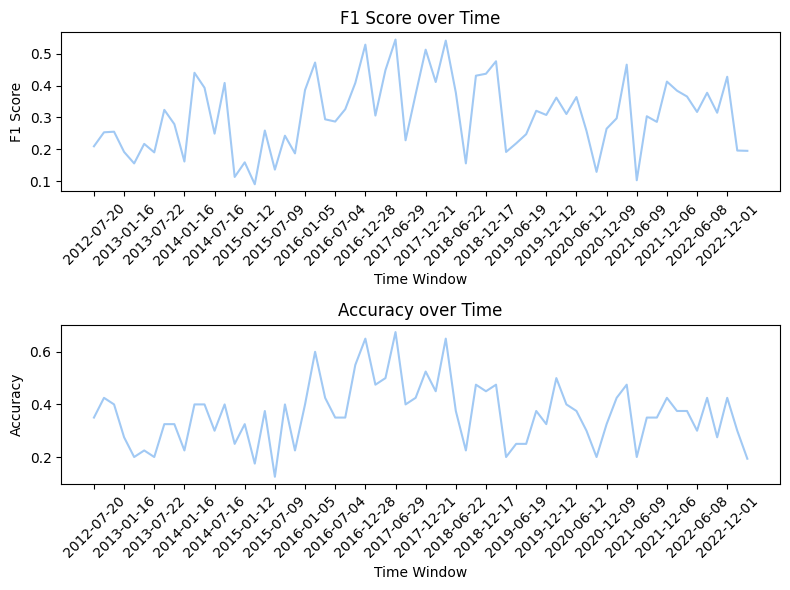

In [91]:
# Initialize empty lists to store the F1 score and accuracy for each time window
f1_scores = []
accuracies = []
x_ticks = []

# Loop over the data in 40-day windows
for i in range(0, len(predictions), 40):
    # Get the data for the current 40-day window
    window_data = predictions.iloc[i:i+40]
    
    # Compute the F1 score and accuracy for the current window
    f1 = f1_score(window_data['true'], window_data['prediction'], average='weighted')
    accuracy = accuracy_score(window_data['true'], window_data['prediction'])
    
    # Append the results to the lists
    f1_scores.append(f1)
    accuracies.append(accuracy)
    
    # Get the end date for the current window
    end_date = window_data.iloc[-1]['date']
    x_ticks.append(str(end_date))

# Create a new DataFrame to store the results
results = pd.DataFrame({'F1 score': f1_scores, 'Accuracy': accuracies})

# Plot the F1 score and accuracy as line graphs
fig, axs = plt.subplots(2, figsize=(8, 6))
# results.plot(y='F1 score', kind='line', ax=axs[0], xlabel='Time Window', ylabel='F1 Score', title='F1 Score over Time')
axs[0].plot(x_ticks, results['F1 score'])
axs[0].set_xlabel("Time Window")
axs[0].set_ylabel("F1 Score")
axs[0].set_title("F1 Score over Time")
axs[0].set_xticks(x_ticks[::3])
axs[0].set_xticklabels(x_ticks[::3], rotation=45)
# results.plot(y='Accuracy', kind='line', ax=axs[1], xlabel='Time Window', ylabel='Accuracy', title='Accuracy over Time')
axs[1].plot(x_ticks, results['Accuracy'])
axs[1].set_xlabel("Time Window")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy over Time")
axs[1].set_xticks(x_ticks[::3])
axs[1].set_xticklabels(x_ticks[::3], rotation=45)
plt.tight_layout()
plt.show()

It seems that both the F1 score and accuracy are highly volatile and fluctuating over time, without any clear overall trend. The trends for both metrics are generally similar, suggesting that the model's performance is not biased towards one metric over the other.

However, it's worth noting that the F1 score and accuracy both exhibit a wide range of values, with the F1 score ranging from 0.09 to 0.54 and the accuracy ranging from 0.125 to 0.675. This suggests that the model's performance varies widely over time and across different time windows, and that there may be certain time periods where the model performs significantly better or worse than others. In particular, those periods with very high accuracies and F1 scores usually follow those with low accuracies and F1 scores.

This suggests that the model's performance is not consistent over time and across different time windows and it may be worth exploring more advanced modeling techniques that take into account the temporal nature of the data. 

**Hyperparameters**


In [93]:
parameters = pd.read_csv("../model/demo/mlr_000016/hyperparam.csv")
parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_date  66 non-null     object 
 1   end_date    66 non-null     object 
 2   best_c      66 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.7+ KB


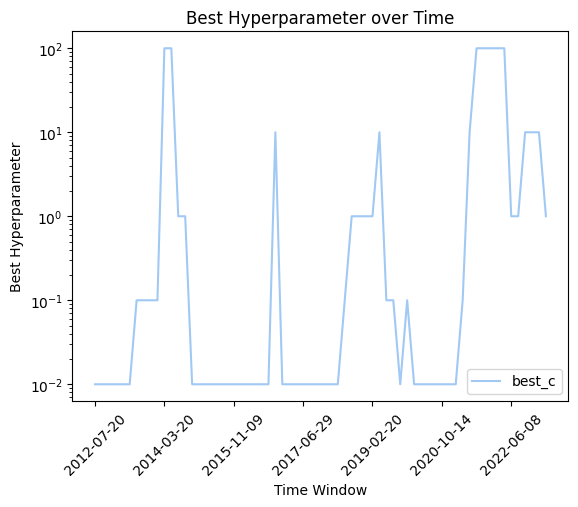

In [98]:
parameters.plot(x="end_date", y="best_c", xlabel="Time Window", ylabel="Best Hyperparameter", title="Best Hyperparameter over Time", rot=45, logy=True)
plt.show()

Based on the plot of the best hyperparameter value over time, it appears that the value is highly unstable and varies widely, ranging from 0.1 to 100 over time. This suggests that more advanced models that can take time into account may be necessary, rather than relying on the baseline multi-logistic regression model. 